In [ ]:
input_file1 = "QM9_129440_MLtraining"
input_file2 = "QM9_49762_MLtraining"

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pickle
import os
df1 = pd.read_csv(f'{input_file1}.csv')
df2 = pd.read_csv(f'{input_file2}.csv')
print(df2.info())
print(df2.describe())

print(df2.isnull().sum().sort_values(ascending=False))
df2 = df2.dropna()
df2 = df2.replace([np.inf, -np.inf], np.nan).dropna()
numeric_columns = df2.select_dtypes(include=[np.number]).columns

# Calculate IQR and remove outliers for each numeric column
for column in numeric_columns:
    Q1 = df2[column].quantile(0.25)
    Q3 = df2[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df2 = df2[(df2[column] >= lower_bound) & (df2[column] <= upper_bound)]

print("Shape after cleaning:", df2.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49762 entries, 0 to 49761
Data columns (total 59 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   canonical_smiles  49762 non-null  object 
 1   mps_pred          49762 non-null  float64
 2   bps_pred          49762 non-null  float64
 3   fps_pred          49762 non-null  float64
 4   #C                49762 non-null  int64  
 5   #O                49762 non-null  int64  
 6   #O/#C             49761 non-null  float64
 7   #Halogen          49762 non-null  int64  
 8   #Halogen/#H       49733 non-null  float64
 9   #R=R              49762 non-null  int64  
 10  #R#R              49762 non-null  int64  
 11  #Donor            49762 non-null  int64  
 12  #Accept           49762 non-null  int64  
 13  #Ring             49762 non-null  int64  
 14  #AlCR             49762 non-null  int64  
 15  #AlHR             49762 non-null  int64  
 16  #AlR              49762 non-null  int64 

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


           mps_pred      bps_pred      fps_pred            #C            #O  \
count  49762.000000  49762.000000  49762.000000  49762.000000  49762.000000   
mean     275.854000    452.521807    336.486298      6.749186      1.311885   
std       66.147702     36.123825     32.569142      1.337912      0.877171   
min       85.450000    182.520000    180.875000      0.000000      0.000000   
25%      227.636364    427.204545    311.772727      6.000000      1.000000   
50%      267.375000    449.250000    334.329545      7.000000      1.000000   
75%      315.250000    477.477273    359.181818      8.000000      2.000000   
max      613.227273    578.181818    439.295455      9.000000      5.000000   

              #O/#C      #Halogen  #Halogen/#H          #R=R          #R#R  \
count  4.976100e+04  49762.000000      49733.0  49762.000000  49762.000000   
mean            inf      0.036172          inf      0.717596      0.318496   
std             NaN      0.268107          NaN      0.

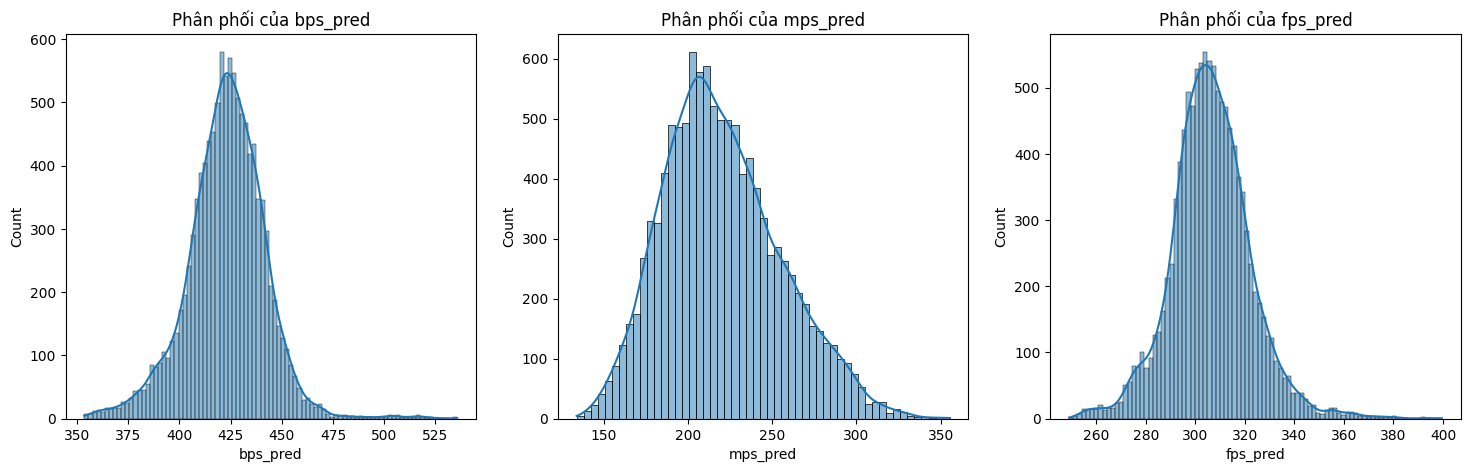

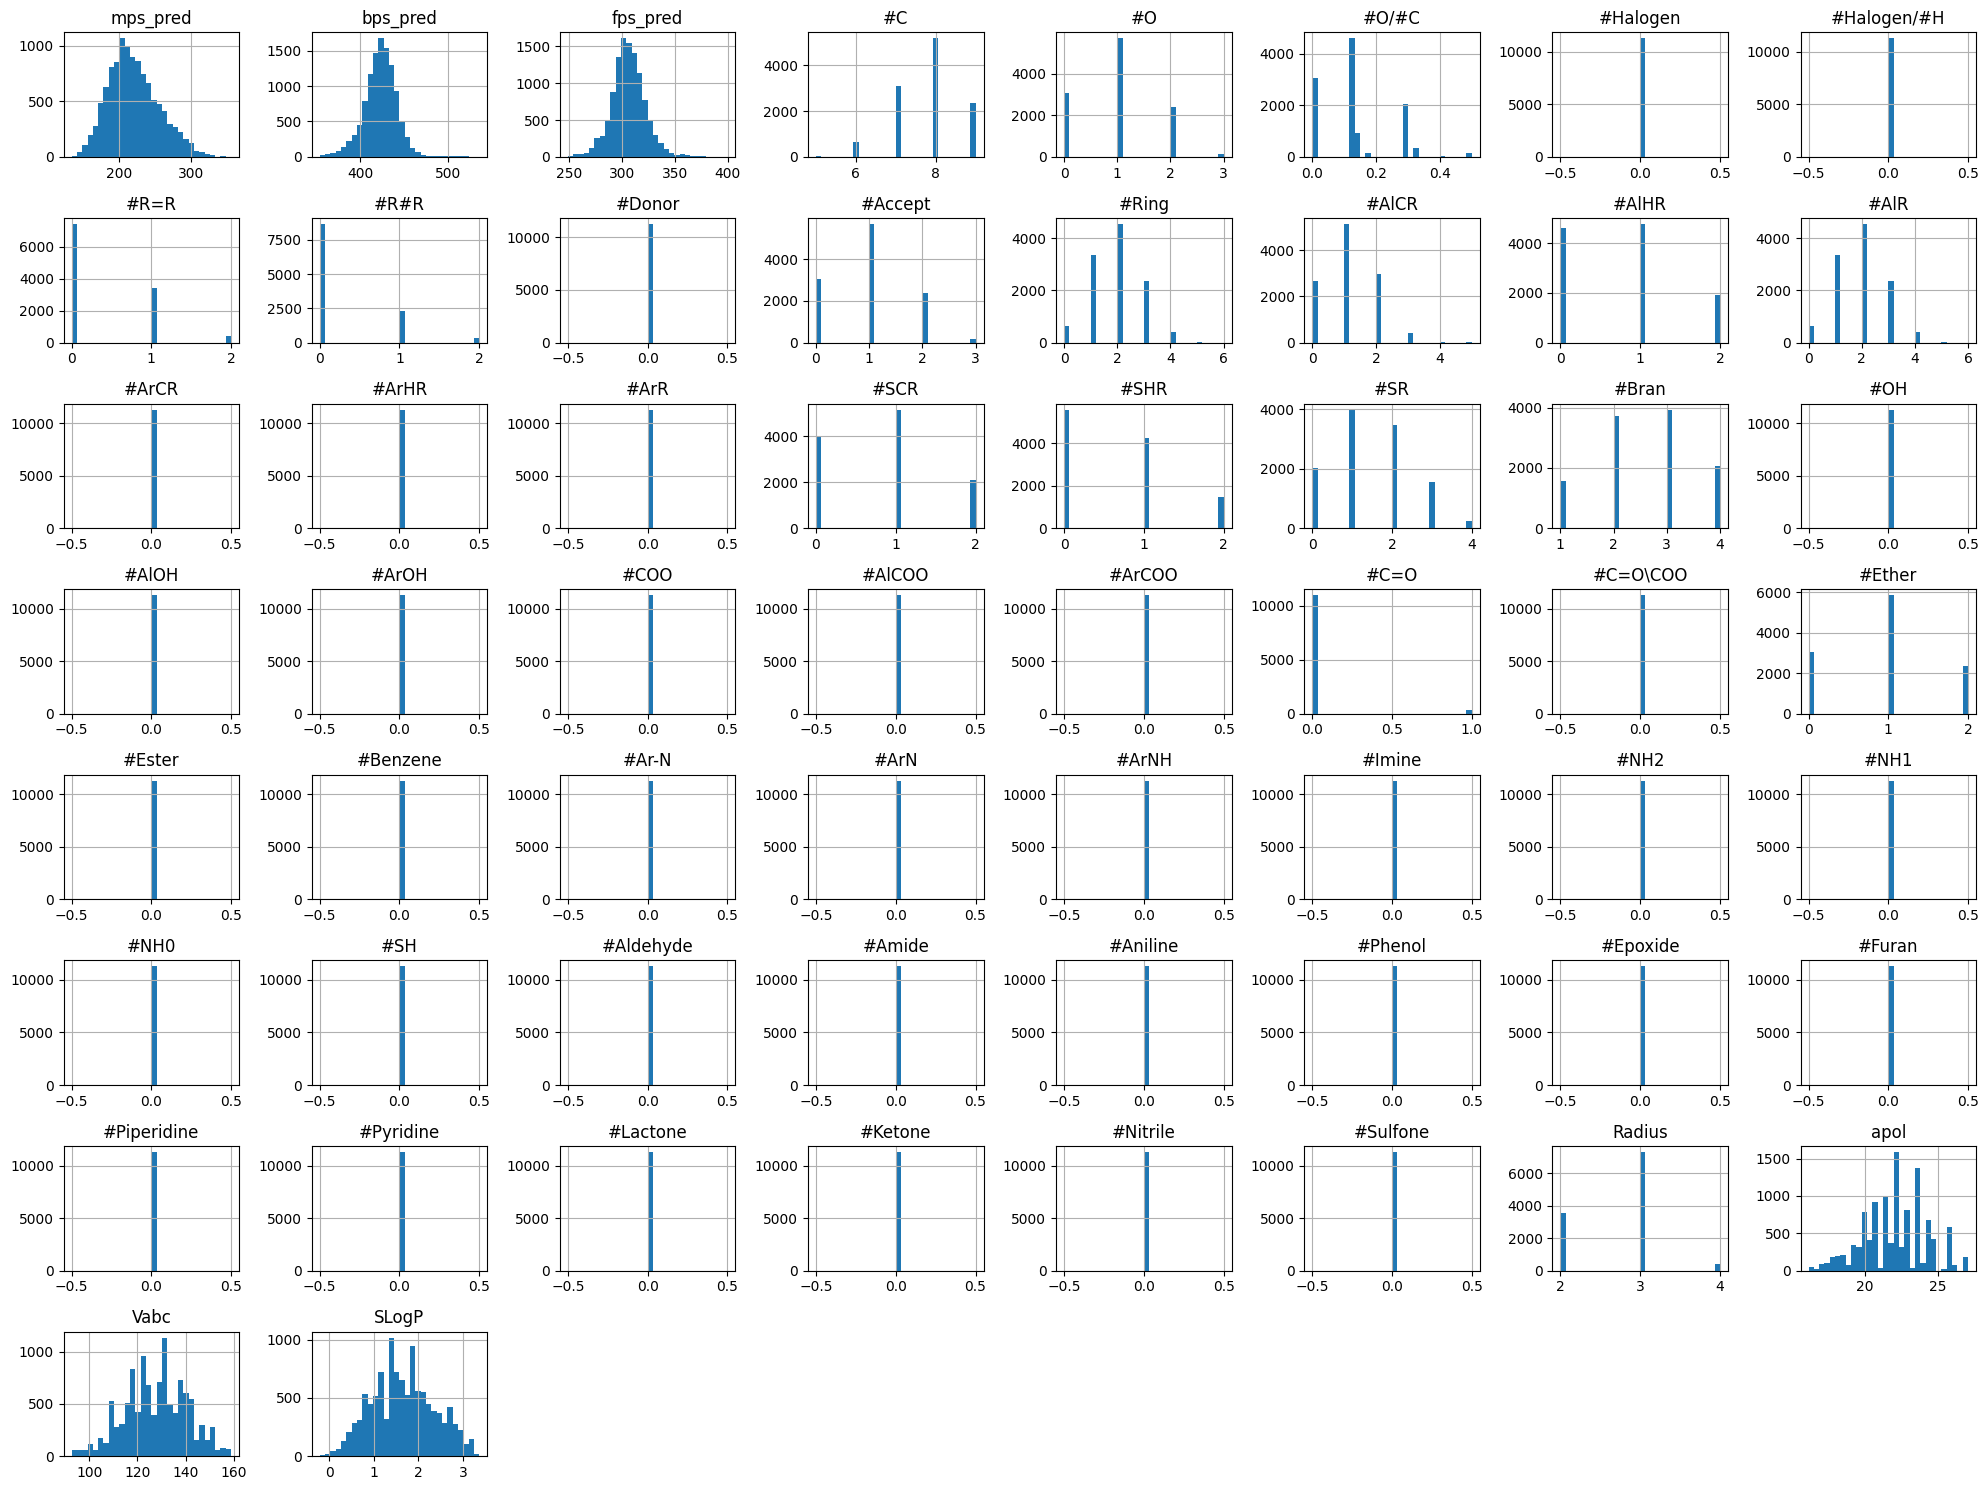

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Phân phối target variables
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, target in enumerate(['bps_pred', 'mps_pred', 'fps_pred']):
    sns.histplot(df2[target], kde=True, ax=axes[i])
    axes[i].set_title(f'Phân phối của {target}')
plt.show()

# Phân phối các features numeric
numeric_cols = df2.select_dtypes(include=['float64', 'int64']).columns
df2[numeric_cols].hist(bins=30, figsize=(20, 15))
plt.tight_layout()
plt.show()

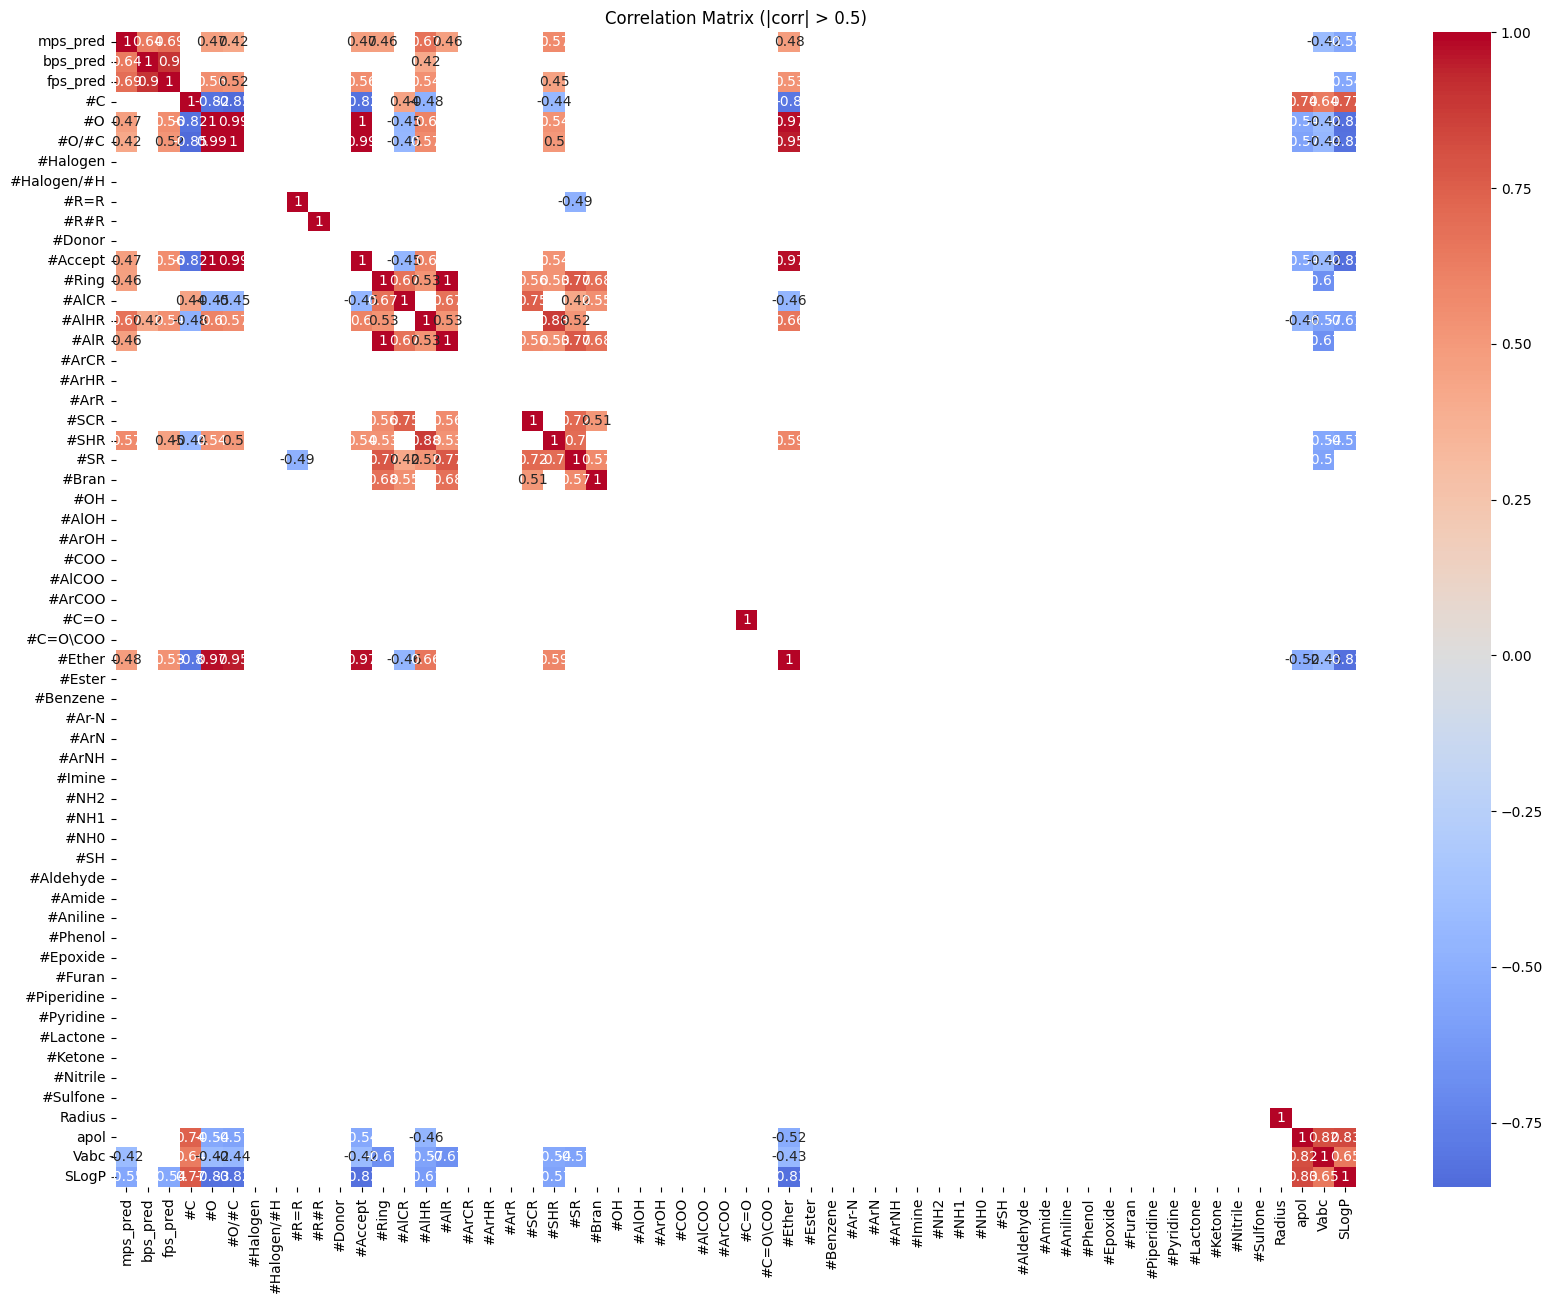


Tương quan với bps_pred:
bps_pred    1.000000
fps_pred    0.900453
mps_pred    0.635501
#AlHR       0.419499
#O          0.377085
#Accept     0.377085
#Ether      0.366345
#O/#C       0.339580
#Ring       0.337146
#AlR        0.337146
#SHR        0.332013
SLogP      -0.341967
Name: bps_pred, dtype: float64

Tương quan với mps_pred:
mps_pred    1.000000
fps_pred    0.694161
#AlHR       0.671646
bps_pred    0.635501
#SHR        0.568917
#Ether      0.484587
#Accept     0.465604
#O          0.465604
#Ring       0.457892
#AlR        0.457892
#O/#C       0.423361
#SR         0.316973
apol       -0.396790
Vabc       -0.415609
SLogP      -0.545900
Name: mps_pred, dtype: float64

Tương quan với fps_pred:
fps_pred    1.000000
bps_pred    0.900453
mps_pred    0.694161
#Accept     0.556394
#O          0.556394
#AlHR       0.538507
#Ether      0.534662
#O/#C       0.521724
#SHR        0.451003
SLogP      -0.537281
Name: fps_pred, dtype: float64


In [14]:
# Ma trận tương quan
corr_matrix = df2.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix[(corr_matrix > 0.4) | (corr_matrix < -0.4)], 
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (|corr| > 0.5)')
plt.show()

# Tương quan với target
targets = ['bps_pred', 'mps_pred', 'fps_pred']
for target in targets:
    corr_with_target = df2.select_dtypes(include=['float64', 'int64']).corr()[target].sort_values(ascending=False)
    print(f"\nTương quan với {target}:")
    print(corr_with_target[abs(corr_with_target) > 0.3])


Feature importance cho bps_pred:
    feature  importance
11    #AlHR    0.239269
54    SLogP    0.170299
0        #C    0.153903
53     Vabc    0.090408
2     #O/#C    0.063866
52     apol    0.041204
51   Radius    0.039624
19    #Bran    0.038802
1        #O    0.034071
8   #Accept    0.033877
28   #Ether    0.017937
26     #C=O    0.016408
5      #R=R    0.015047
9     #Ring    0.007850
10    #AlCR    0.007652
17     #SHR    0.007527
12     #AlR    0.007236
16     #SCR    0.005919
18      #SR    0.005684
6      #R#R    0.003417


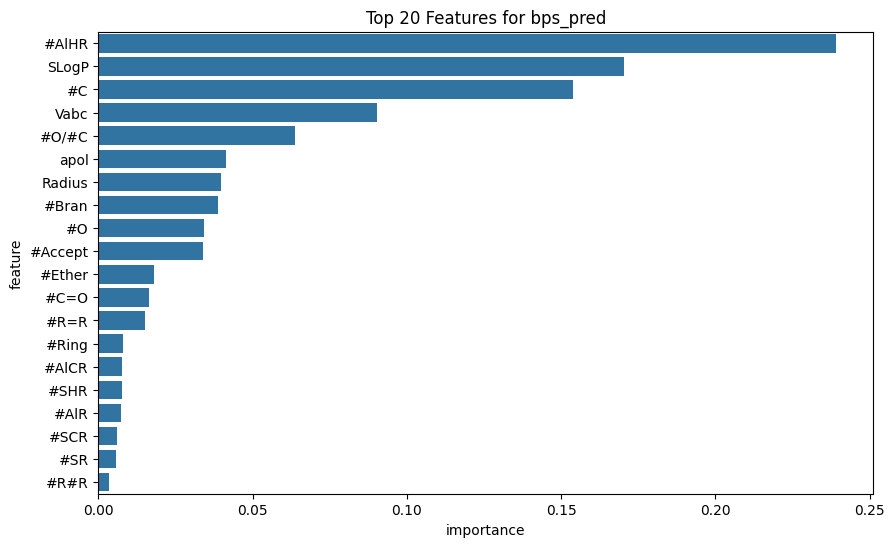


Feature importance cho mps_pred:
    feature  importance
11    #AlHR    0.578348
54    SLogP    0.104344
5      #R=R    0.042953
53     Vabc    0.041042
6      #R#R    0.031102
52     apol    0.026192
51   Radius    0.026176
19    #Bran    0.024563
0        #C    0.018237
16     #SCR    0.015720
18      #SR    0.015142
9     #Ring    0.014412
10    #AlCR    0.013899
12     #AlR    0.013459
2     #O/#C    0.010802
17     #SHR    0.010759
1        #O    0.004429
8   #Accept    0.004065
28   #Ether    0.003039
26     #C=O    0.001314


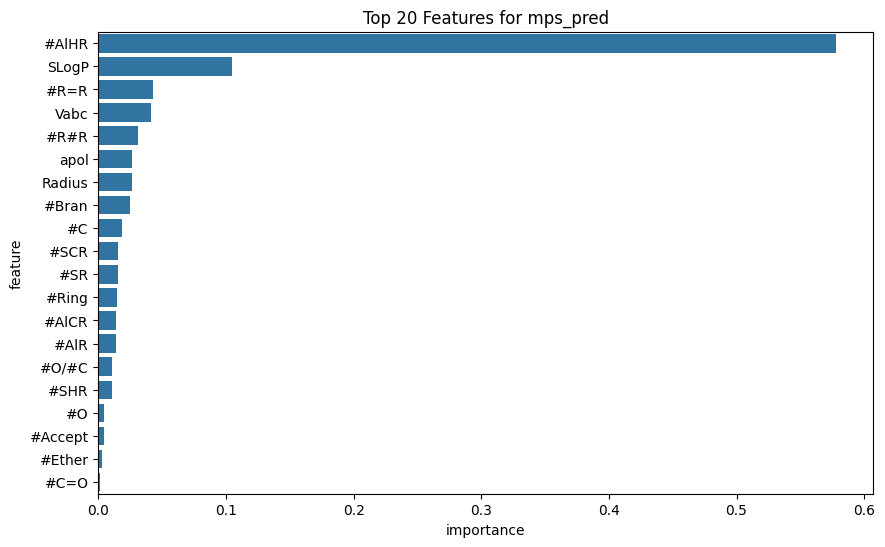


Feature importance cho fps_pred:
    feature  importance
11    #AlHR    0.373877
54    SLogP    0.152708
53     Vabc    0.131870
0        #C    0.053783
52     apol    0.045570
26     #C=O    0.041317
51   Radius    0.038600
2     #O/#C    0.036812
19    #Bran    0.023809
1        #O    0.019763
6      #R#R    0.019199
8   #Accept    0.017688
10    #AlCR    0.007907
16     #SCR    0.007707
28   #Ether    0.005783
17     #SHR    0.005328
18      #SR    0.005159
5      #R=R    0.004832
12     #AlR    0.004340
9     #Ring    0.003949


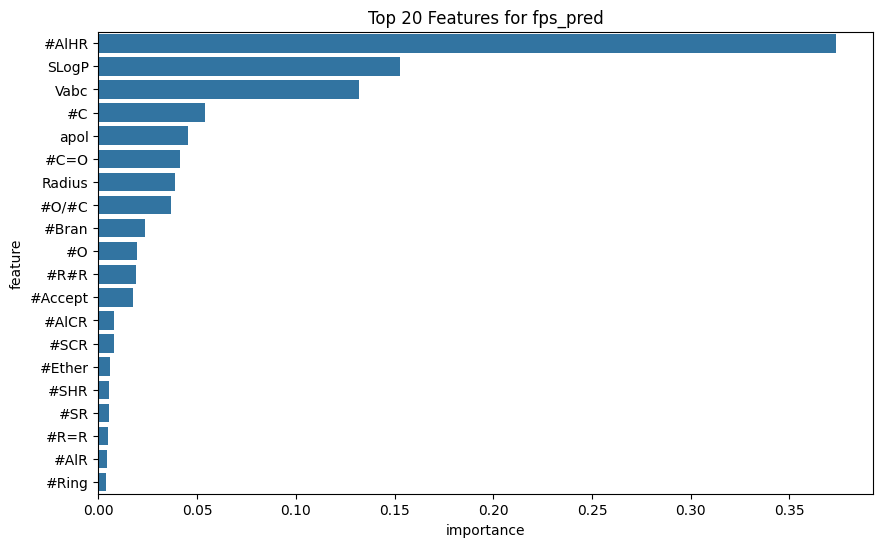

In [ ]:
# frature importance từ mô hình
from sklearn.ensemble import RandomForestRegressor

# Tính feature importance cho từng target
for target in ['bps_pred', 'mps_pred', 'fps_pred']:
    X = df2.drop(columns=['bps_pred', 'mps_pred', 'fps_pred', 'canonical_smiles'])
    y = df2[target]
    
    model = RandomForestRegressor(n_estimators=100, random_state=7)
    model.fit(X, y)
    
    importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nFeature importance cho {target}:")
    print(importance.head(20))
    
    # Visualize top 20 features
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance.head(20))
    plt.title(f'Top 20 Features for {target}')
    plt.show()

In [ ]:
# chọn feaatures bằng thống kê
from sklearn.feature_selection import SelectKBest, mutual_info_regression

for target in ['bps_pred', 'mps_pred', 'fps_pred']:
    X = df2.drop(columns=['bps_pred', 'mps_pred', 'fps_pred'])
    y = df2[target]
    
    # Chọn top k features dựa trên mutual information
    selector = SelectKBest(score_func=mutual_info_regression, k=20)
    selector.fit(X, y)
    
    selected_features = X.columns[selector.get_support()]
    scores = selector.scores_[selector.get_support()]
    
    print(f"\nTop features cho {target} (Mutual Info):")
    print(pd.DataFrame({'feature': selected_features, 'score': scores})
          .sort_values('score', ascending=False))

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=20 is greater than n_features=18. All the features will be returned.
  warnings.warn(



Top features cho bps_pred (Mutual Info):
    feature     score
15     apol  0.416714
16     Vabc  0.341294
17    SLogP  0.200284
7     #AlHR  0.136611
0        #C  0.104739
1        #O  0.100581
4   #Accept  0.100479
13   #Ether  0.093031
8      #AlR  0.091622
5     #Ring  0.091515
10     #SHR  0.085078
11      #SR  0.043014
14   Radius  0.036707
6     #AlCR  0.024098
2      #R=R  0.023742
12    #Bran  0.020420
9      #SCR  0.007447
3      #R#R  0.000113


c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=20 is greater than n_features=18. All the features will be returned.
  warnings.warn(



Top features cho mps_pred (Mutual Info):
    feature     score
15     apol  0.427599
16     Vabc  0.424740
17    SLogP  0.349225
7     #AlHR  0.308370
10     #SHR  0.199992
1        #O  0.165567
4   #Accept  0.165522
13   #Ether  0.162840
8      #AlR  0.142793
5     #Ring  0.142710
0        #C  0.093361
11      #SR  0.082831
12    #Bran  0.049120
9      #SCR  0.027707
3      #R#R  0.027644
14   Radius  0.025818
6     #AlCR  0.021879
2      #R=R  0.017433


c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=20 is greater than n_features=18. All the features will be returned.
  warnings.warn(



Top features cho fps_pred (Mutual Info):
    feature     score
15     apol  0.565313
16     Vabc  0.467191
17    SLogP  0.330862
7     #AlHR  0.231567
4   #Accept  0.213585
1        #O  0.213361
13   #Ether  0.192370
0        #C  0.179396
10     #SHR  0.164023
11      #SR  0.047635
6     #AlCR  0.045036
5     #Ring  0.041386
8      #AlR  0.041017
14   Radius  0.038700
3      #R#R  0.019156
9      #SCR  0.015601
12    #Bran  0.015165
2      #R=R  0.001658
